# Lab 4: Building a Spotify Song Classifier with KNNs and Decision Trees
**Classify by genres**. In this lab, you will build machine learning genre classifiers using a dataset of Spotify tracks. Your goal is to train a model that can distinguish between two selected genres based on various audio features such as danceability, energy, valence, tempo, and more.

We'll follow the familiar workflow of data exploration -> preprocessing -> model training -> evaluation

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

### Step 1: The data
We'll focus on two genres: Blues and Jazz (what’s the difference, anyway??).

Both genres have rich musical histories, but they differ in structure:

- Blues tends to have simpler chord progressions and a strong emotional expression.
- Jazz often involves complex improvisation and more varied rhythms.

But can a machine really tell them apart just by looking at numerical audio features? That’s what we’ll find out!

In this step, you will:
- Load the dataset
- Extract only blues and jazz for classification

In [ ]:
# ---- read and clean data ----
spotify_data = pd.read_csv('/courses/EDS232/Data/spotify_dat.csv')
                        

# Print the data types in spotify_data
print(spotify_data.dtypes)

# Filter down to two genres
blues_data =  spotify_data[spotify_data['genres']== 'blues']
jazz_data =  spotify_data[spotify_data['genres']== 'jazz']

# Combine both genres into one dataset
combined_data =  pd.concat([blues_data,jazz_data])

# Rename 'genres' column to 'genre' for clarity
# Renaming columns
combined_data = combined_data.rename(columns = {'genres': 'genre'})

print(combined_data)

## Step 2: Data Exploration
Now that we have Blues and Jazz as our two genres, it's time to explore the data and look for patterns in the audio features.

Let's investigate:
- Which features are available?
- How strongly these features correlate with each other.
- How different genres distribute across  sample features: danceability 

In this step, we will:
- Filter out non-numeric columns before the plotting
- Visualize feature correlations using a heatmap.
- Examine key feature distributions with histograms to see if genres behave differently.


Columns are:  ['id', 'name', 'album', 'album_id', 'artists', 'artist_ids', 'track_number', 'disc_number', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'year', 'release_date', 'genre']


Text(50.58159722222221, 0.5, 'Jazz Features')

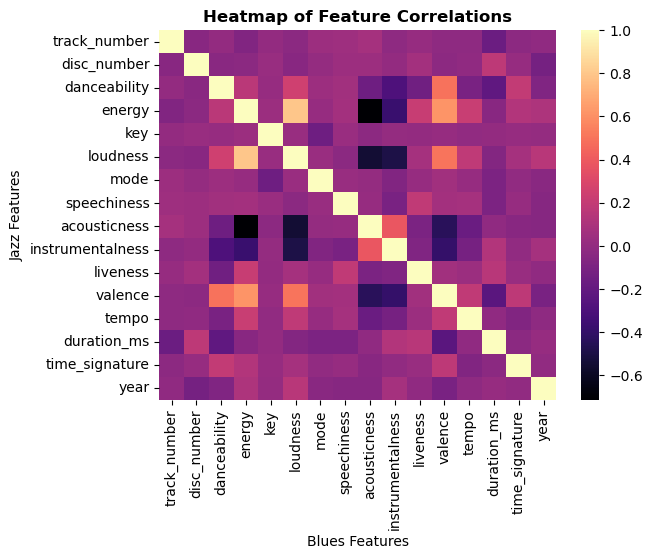

In [4]:
# Print columns
print("Columns are: ",list(combined_data.columns))

# Exclude non-numeric columns but keep 'genre' for grouping
numeric_features = combined_data.select_dtypes(include='number').copy()

# Add genre back to numeric feature df
numeric_features['genre'] = combined_data['genre']

# Plot correlation heatmap
plt.title('Heatmap of Feature Correlations', fontweight='bold')
corr_heatmap = sns.heatmap(numeric_features.corr(),
                           cmap="magma")

plt.xlabel("Blues Features")
plt.ylabel("Jazz Features")

Text(0.5, 1.0, 'Histogram of Danceability')

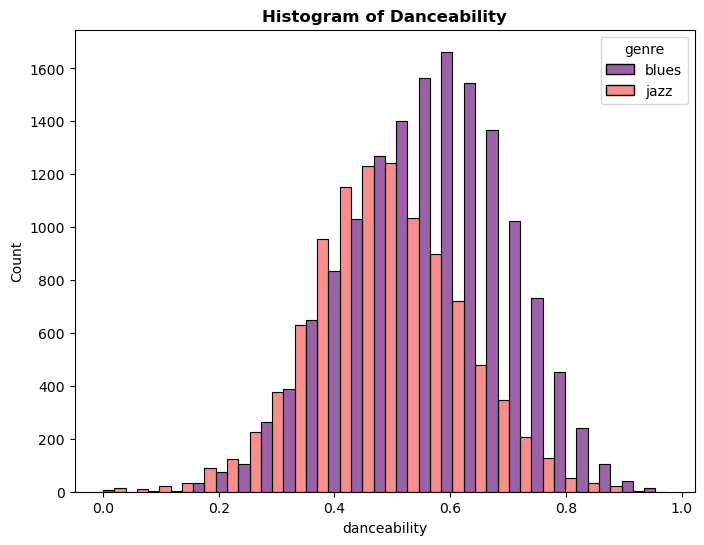

In [5]:
# Histogram of danceability
plt.figure(figsize=(8, 6))
sns.histplot(data=numeric_features,
             x = "danceability",
             hue = "genre",
             bins = 25,
             alpha = 0.7,
             palette = "magma",
             multiple = "dodge")

plt.title('Histogram of Danceability',
          fontweight='bold')

Text(0.5, 1.0, 'Histogram of Valence')

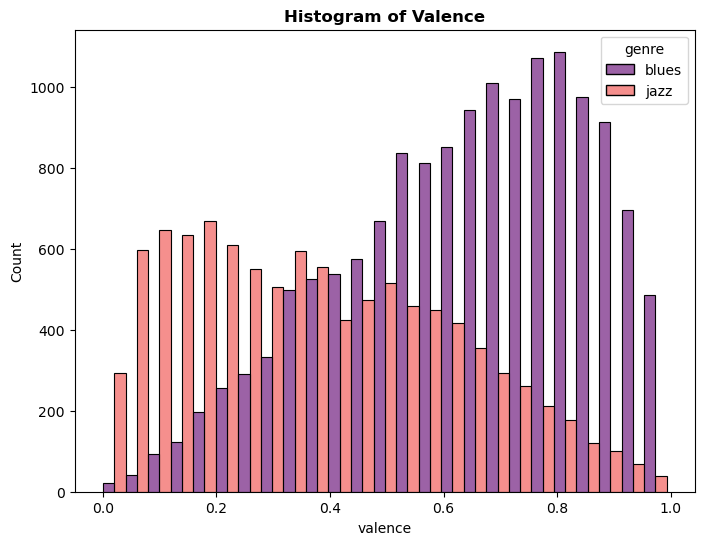

In [5]:
# Histogram of valence
plt.figure(figsize=(8, 6))
sns.histplot(data=numeric_features,
             x = "valence",
             hue = "genre",
             bins = 25,
             alpha = 0.7,
             palette = "magma",
             multiple = "dodge")

plt.title('Histogram of Valence',
          fontweight='bold')

Text(0.5, 1.0, 'Histogram of Energy')

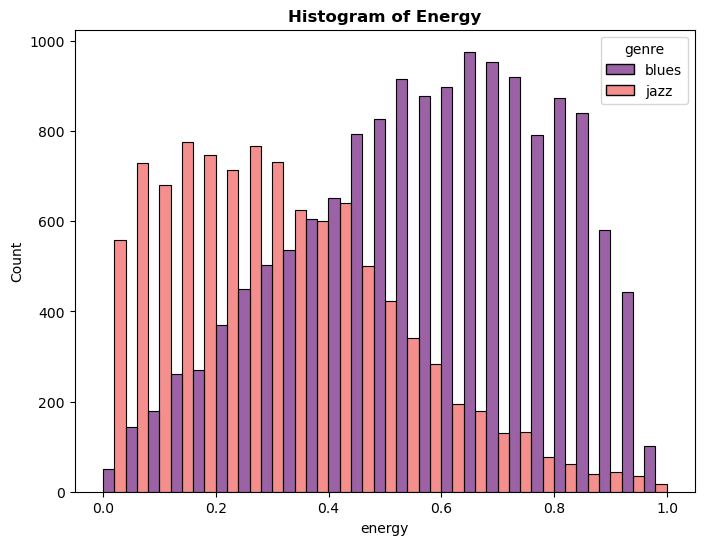

In [6]:
# Histogram of danceability
plt.figure(figsize=(8, 6))
sns.histplot(data=numeric_features,
             x = "energy",
             hue = "genre",
             bins = 25,
             alpha = 0.7,
             palette = "magma",
             multiple = "dodge")

plt.title('Histogram of Energy',
          fontweight='bold')

Text(0.5, 1.0, 'Histogram of Acousticness')

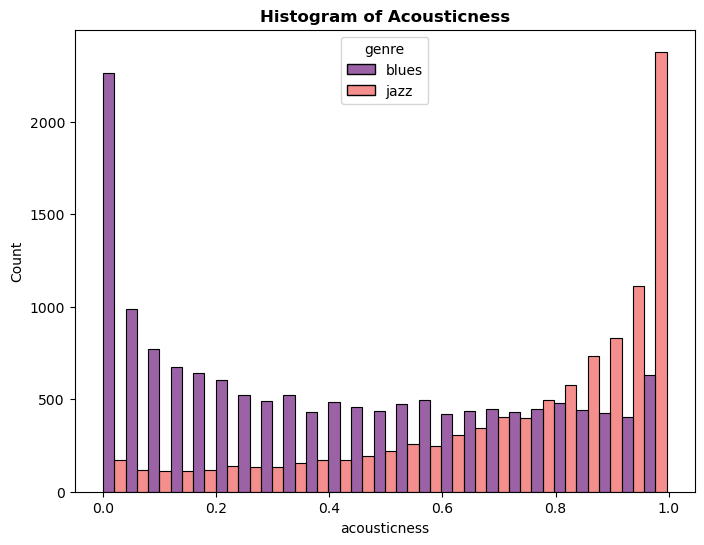

In [7]:
# Histogram of acousticness
plt.figure(figsize=(8, 6))
# Create a histogram with different colors for each genre
sns.histplot(data=numeric_features,
             x = "acousticness",
             hue = "genre",
             bins = 25,
             alpha = 0.7,
             palette = "magma",
             multiple = "dodge")

plt.title('Histogram of Acousticness',
          fontweight='bold')

Text(0.5, 1.0, 'Histogram of loudness')

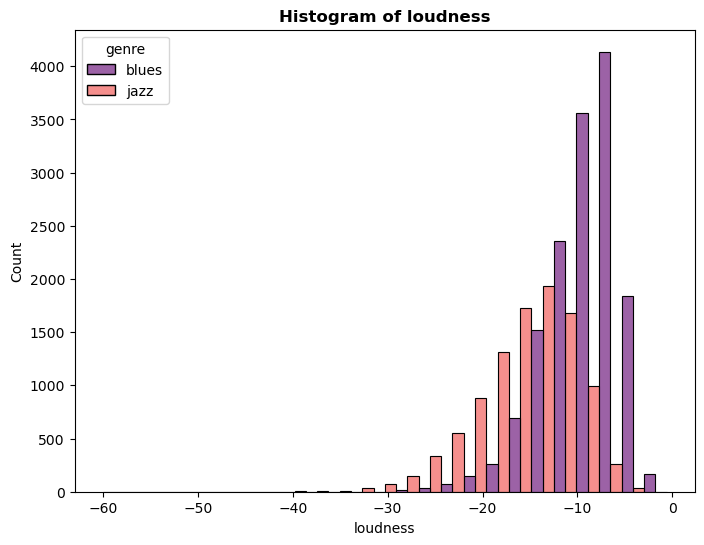

In [8]:
# Histogram of loudness
plt.figure(figsize=(8, 6))
# Create a histogram with different colors for each genre
sns.histplot(data=numeric_features,
             x = "loudness",
             hue = "genre",
             bins = 25,
             alpha = 0.7,
             palette = "magma",
             multiple = "dodge")

plt.title('Histogram of loudness',
          fontweight='bold')

### Step 3: Check for class imbalance
An unequal distribution between the target classes can cause issues for our classifiers, so we'll need to check for that. A commonly used guideline for class imbalance is:

- Slight Imbalance (Less than 1.5:1) → Generally okay; no need for balancing.
- Moderate Imbalance (Between 1.5:1 and 3:1) → Might cause some bias; balancing can help.
- Severe Imbalance (More than 3:1) → Strongly affects model performance; balancing is usually necessary.

In [7]:
# Print counts of each genre
class_counts = numeric_features["genre"].value_counts()
print("Class counts:", class_counts)

# Calculate ratio of majority to minority class
class_ratio = numeric_features["genre"].value_counts()[0]/numeric_features["genre"].value_counts()[1]

# Print class distribution and ratio
print("Class ratio", class_ratio)

Class counts: blues    14811
jazz     10023
Name: genre, dtype: int64
Class ratio 1.4777012870398085


Given this result, should we be worried about the imbalance?

The majority to minority class ratio is 1.4 ( < 1.5), which indicates a slight imbalance. In this case it should be okay to move forward without the need for balancing. 

### Step 4: Preprocessing
We need to ensure all the variables we use are numerical so the models can process them. First we'll drop all the variables that are not numeric or the target. Then we'll use a sklearn utility, `LabelEncoder()` to encode our categorical target variable into numerical values. Print the first five values of your encoded labels.

In [10]:
# Define the features (drop columns that are not numeric or target)
X = numeric_features.select_dtypes(include='number')

# Set the target variable as 'genre'
y =  numeric_features.genre

# Encode the target variable ('label') using label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print first five values of encoded labels
print("First five values of encoded labels:", y_encoded[:5])

First five values of encoded labels: [0 0 0 0 0]


Good, now we'll do our data splitting and scaling.  Let's go with an 80/20 split this time.

In [11]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the training set
X_train_scaled = scaler.fit_transform(X_train) 

# Use the same scaler to transform the test set
X_test_scaled = scaler.fit_transform(X_test)

### Step 5: Train the models
OK, now it's time to build our models and assess the training accuracy. We'll use the default of k = 5 for the KNN model.

In [12]:
# Initialize models
knn = KNeighborsClassifier(n_neighbors = 5)
dt = DecisionTreeClassifier()

# Train (fit) both models
knn.fit(X_train_scaled, y_train)
dt.fit(X_train_scaled, y_train)

# Predictions on training data
knn_y_train_pred = knn.predict(X_train_scaled)
dt_y_train_pred = dt.predict(X_train_scaled)

# Print training accuracy for both models
knn_train_accuracy = accuracy_score(y_train, knn_y_train_pred)
dt_train_accuracy = accuracy_score(y_train, dt_y_train_pred)

# print accuracy
print(f"KNN - Train Accuracy: {knn_train_accuracy:.3f}")
print(f"DT - Train Accuracy: {dt_train_accuracy:.3f}")

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNN - Train Accuracy: 0.918
DT - Train Accuracy: 1.000


### Step 6: Evaluate models
OK, now let's go ahead and predict on the test data to see how well our models do at predicting the genre of unseen tracks.

In [13]:
# Make predictions
knn_pred = knn.predict(X_test_scaled)
dt_pred = dt.predict(X_test_scaled)

# Evaluate prediction accuracy
knn_accuracy = accuracy_score(y_test, knn_pred)
dt_accuracy = accuracy_score(y_test, dt_pred)

#Print prediction accuracy for both models
print(f"KNN - Test Accuracy: {knn_accuracy:.3f}")
print(f"DT - Test Accuracy: {dt_accuracy:.3f}")

KNN - Test Accuracy: 0.891
DT - Test Accuracy: 0.848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Step 7: Visualizing Model Performance
Now that we have evaluated our models on unseen data, let’s compare their performance by visualizing the training vs. test accuracy.  We'll look for signs of overfitting by plotting the training accuracy and test accuracy for both k-NN and Decision Trees.

Create a bar chart that compares the training accuracy and test accuracy for k-NN and Decision Trees. Your plot should clearly display:

- The training and test accuracy for both models.
- Properly labeled axes and a title.
- A legend to differentiate training and test accuracy.
- Accuracy values displayed on top of each bar.

In [14]:
# Set up accuracies for plot
models = ['KNN', 'DT']
train_accuracies = [knn_train_accuracy, dt_train_accuracy]
test_accuracies = [knn_accuracy, dt_accuracy]

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1000x600 with 0 Axes>

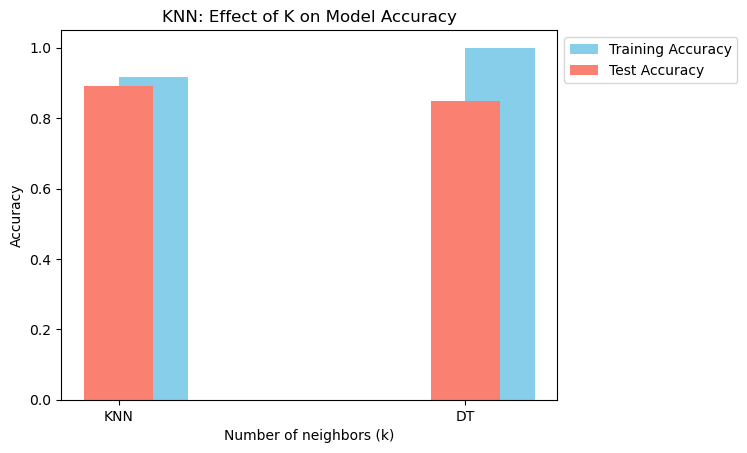

In [15]:
# Visualize the training and test accuracy for KNN and DT models

plt.figure(figsize = (10,6))

# Create the bar chart
fig, ax = plt.subplots()

# Plot the training and test accuracy
ax.bar(models, train_accuracies, width=0.2, label='Training Accuracy', color='skyblue', align = "edge")
ax.bar(models, test_accuracies, width=0.2, label='Test Accuracy', color='salmon')

plt.plot(knn_accuracy, )
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN: Effect of K on Model Accuracy')
plt.legend(bbox_to_anchor=(1, 1))
plt.show

Which model does a better job of generalizing to unseen data? How do you know?
Does it appear that either of the models are overfitting? Why?

The KNN model received an accuracy of .89% on the test data and the DT model got an accuracy of .84. The KNN generalized a bit better than the DT model, since it ended up getting similar accuracy to it's training model. The DT model shows a definite sign of overfitting, since it received a "100%" for the training accuracy and went down to .84 when we generalized to the testing data. We did not set a maxdepth in the DT model, so it just endleslly split until the nodes matched the training data. This led it to capture noise as well as signal in the data and led to it not being able to generalize as well.

### Bonus question
In the workflow above, we used the default parameter values of k = 5 for the KNN model, and maxdepth = None for the Decision Tree. Choose one of the models and see if you can improve test performance by optmizing its corresponding parameter value.

In [16]:
# ---- Try to improve DT model performance ----

# Define DT with max depth set to 6
dt_6 = DecisionTreeClassifier(max_depth = 6)

# Train model
dt_6.fit(X_train_scaled, y_train)

# Predictions on training data
dt_6_y_train_pred = dt_6.predict(X_train_scaled)

# Print training accuracy for both models
dt_6_train_accuracy = accuracy_score(y_train, dt_6_y_train_pred)

# Print accuracy
print(f"Original DT - Train Accuracy: {dt_train_accuracy:.3f}")
print(f"New DT6 - Train Accuracy: {dt_6_train_accuracy:.3f}\n")

# Make predictions
dt_6_pred = dt_6.predict(X_test_scaled)

# Evaluate prediction accuracy
dt_6_accuracy = accuracy_score(y_test, dt_6_pred)

# Print prediction accuracy for both models
print(f"Original DT - Test Accuracy: {dt_accuracy:.3f}")
print(f"New DT5 - Test Accuracy: {dt_6_accuracy:.3f}")

Original DT - Train Accuracy: 1.000
New DT6 - Train Accuracy: 0.888

Original DT - Test Accuracy: 0.848
New DT5 - Test Accuracy: 0.872


By changing the max depth to 6, I was able to improve the testing accuracy to .87, which was a significant improvement compared to the overfit model with no max depth set. I also tried a run with md = 5, but md = 6 performed better. It didn't test better than the KNN (k=5) model that we created, but there still may be more room to improve the test performance by optimizing the parameter further.

### Bonus question

In the workflow above, we used the default parameter values of `k = 5` for the KNN model, and `maxdepth = None` for the Decision Tree.  Choose one of the models and see if you can improve test performance by optmizing its corresponding parameter value.